In [ ]:
#@title Neural Network Class
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

def leakyRelu(x):
    return np.where(x > 0, x, 0.01 * x)

def softmax(z):
    ez = np.exp(z - np.max(z, axis = 0))
    return ez / np.sum(ez, axis = 0, keepdims = True)
    #return np.exp(z) / np.sum(np.exp(z), axis = 0, keepdims = True)

def leakyRelu_derivative(x):
    return np.where(x > 0, 1, 0.01)

class NeuralNetwork():
    def __init__(self, layer_size_list):
        '''
        Notation
        L: number of layers in the neural network
        Z[i]: The linear sum of node i
        A[i]: Z[i] after being put in the activation function
        W[i]: Can be written as [W_i1, W_i2, ...].T
        b[i]: The bias vector in layer i

        store: Store Z, A, W
        derivative: Store derivative of dZ[i], dA[i], dW[i] for every layer i from 1 to L
        '''
        self.L = len(layer_size_list)
        self.store = {}
        self.layer_size_list = layer_size_list
        self.train_loss = []
        self.val_loss = []

        self.layer_size_list.insert(0, 0)
        self.derivative = {}

        self.train_acc = []
        self.val_acc = []

        #This is for adam optimizer
        self.m_dw, self.v_dw = {}, {}
        self.m_db, self.v_db = {}, {}

    #Initializing the parameters for each unit in each layer
    def initParameters(self, input_size):

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.layer_size_list[0] = input_size

        for layer in range(1, self.L + 1):

            layer_size = self.layer_size_list[layer]
            layer_size_prev = self.layer_size_list[layer - 1]

            W_ = np.random.randn(layer_size, layer_size_prev) / np.sqrt(layer_size_prev)
            b_ = np.zeros((layer_size, 1))

            self.m_dw["W" + str(layer)] = np.zeros((layer_size, layer_size_prev))
            self.v_dw["W" + str(layer)] = np.zeros((layer_size, layer_size_prev))
            self.m_db["b" + str(layer)] = np.zeros((layer_size, 1))
            self.v_db["b" + str(layer)] = np.zeros((layer_size, 1))

            self.store["W" + str(layer)] = W_
            self.store["b" + str(layer)] = b_

    def updateParameters(self, layer, t, optimizer, lr, decay = 1, beta1=0.9, beta2=0.999, epsilon=1e-8):
        w = self.store["W" + str(layer)]
        b = self.store["b" + str(layer)]

        dw = self.derivative["dW" + str(layer)]
        db = self.derivative["db" + str(layer)]

        if optimizer == "Adam":


            self.m_dw["W" + str(layer)] = beta1 * self.m_dw["W" + str(layer)] + (1 - beta1) * dw
            self.m_db["b" + str(layer)] = beta1 * self.m_db["b" + str(layer)] + (1 - beta1) * db

            ## rms beta 2
            self.v_dw["W" + str(layer)] = beta2 * self.v_dw["W" + str(layer)] + (1 - beta2) * (dw ** 2)
            self.v_db["b" + str(layer)] = beta2 * self.v_db["b" + str(layer)] + (1 - beta2) * (db ** 2)

            tmp1 = beta1 ** (t // decay + 1)
            tmp2 = beta2 ** (t // decay + 1)

            m_dw_corr = self.m_dw["W" + str(layer)] / (1.- tmp1)
            m_db_corr = self.m_db["b" + str(layer)] / (1.- tmp1)
            v_dw_corr = self.v_dw["W" + str(layer)] / (1.- tmp2)
            v_db_corr = self.v_db["b" + str(layer)] / (1.- tmp2)

            w = w - lr * (m_dw_corr /(np.sqrt(v_dw_corr) + epsilon))
            b = b - lr * (m_db_corr /(np.sqrt(v_db_corr) + epsilon))
        else:

            w = w - lr * dw
            b = b - lr * db

        return w, b
    #Implementation of foward propagation
    def fowardProp(self, X):

        self.store["A0"] = X.T #(L - 1, m)

        for layer in range(1, self.L + 1):
            self.store["Z" + str(layer)] = np.dot(self.store["W" + str(layer)],
                                                  self.store["A" + str(layer - 1)]) +self.store["b" + str(layer)]
            # (L, L - 1) x (L - 1, m) = (L, m)
            if layer != self.L:
                self.store["A" + str(layer)] = leakyRelu(self.store["Z" + str(layer)])
            else:
                self.store["A" + str(layer)] = softmax(self.store["Z" + str(layer)])

    #Implementation of backward propagation (like dynamic programming)

    def backProp(self, X, y):

        n = X.shape[0]

        self.fowardProp(X)

        dZ = self.store["A" + str(self.L)] - y.T #(L, m) - ()
        dW = 1. / n * np.dot(dZ, self.store["A" + str(self.L - 1)].T) #(L, m) * (m, L - 1) = (L, L - 1)
        db = 1. / n * np.sum(dZ, axis = 1).reshape(-1, 1) #(L, m) -> (1, m)

        dA_prev = np.dot(self.store["W" + str(self.L)].T, dZ) #(L - 1, L) x (L, m) = (L - 1, m)

        self.derivative["dW" + str(self.L)] = dW
        self.derivative["db" + str(self.L)] = db

        for l in range(self.L - 1, 0, -1):

            dZ = dA_prev * leakyRelu_derivative(self.store["Z" + str(l)])
            dW = 1. / n * np.dot(dZ, self.store["A" + str(l - 1)].T)
            db = 1. / n * np.sum(dZ, axis = 1).reshape(-1, 1)

            if l > 1:
                dA_prev = np.dot(self.store["W" + str(l)].T, dZ)

            self.derivative["dW" + str(l)] = dW
            self.derivative["db" + str(l)] = db

    #Predict and calculate the accuracy of current sets of parameters
    def predict(self, X, y):
        self.fowardProp(X)
        A_L = self.store["A" + str(self.L)]
        y_hat = np.argmax(A_L, axis = 0) # (L, m) to (1, m)
        y_real = np.argmax(y.T, axis = 0) #(10, m) to (1, m)
        accuracy = (y_hat == y_real).mean()
        return accuracy * 100

    def compute_loss(self, X, y):
        self.fowardProp(X)
        A_l = self.store["A" + str(self.L)]
        loss = -(np.mean(y.T * np.log(A_l + 1e-8)))
        return loss

    #Optimizing using mini-batch gradient descent and regularization method
    def plot_cost(self):
        train_loss = self.train_loss
        val_loss = self.val_loss
        plt.figure()
        plt.plot(np.arange(len(train_loss)), train_loss, label = "train loss")
        plt.plot(np.arange((len(val_loss))), val_loss, label = "validation loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_acc(self):
        train_acc = self.train_acc
        val_acc = self.val_acc
        plt.figure()
        plt.plot(np.arange(len(train_acc)), train_acc, label = "train accuracy")
        plt.plot(np.arange((len(val_acc))), val_acc, label = "validation accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def fit_batch(self, X, y, X_val, y_val, num_iteration, learning_rate, batch_size, optimizer = None):
        alpha_zero = learning_rate
        batches = X.shape[0] // batch_size
        self.initParameters(X.shape[1])
        self.eta = learning_rate
        np.random.seed(42)
        for epoch in range(num_iteration):


            permutation = np.random.permutation(X.shape[0])

            X_shuffled = X[permutation, :]
            y_shuffled = y[permutation, :]

            for batch in range(batches):

                begin_range = batch * batches
                end_range = min(begin_range + batch_size, X.shape[0] - 1)

                X_batch = X_shuffled[begin_range: end_range, :]
                y_batch = y_shuffled[begin_range: end_range, :]

                batch_size_real = end_range - begin_range

                if batch_size_real <= 0:
                    continue

                self.fowardProp(X_batch)
                self.backProp(X_batch, y_batch)

                for l in range(1, self.L + 1):

                    W_new, b_new = self.updateParameters(l, epoch, optimizer, learning_rate)
                    self.store["W" + str(l)] = W_new
                    self.store["b" + str(l)] = b_new

            val_loss = self.compute_loss(X_val, y_val)
            val_acc = self.predict(X_val, y_val)

            train_loss = self.compute_loss(X, y)
            train_accs = self.predict(X, y)

            self.train_loss.append(train_loss)
            self.train_acc.append(train_accs)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)

            #if (epoch + 1) % 10 == 0:
            print("Iteration: {}, Train loss: {}, Val loss: {}, Accuracy on train: {}, Accuracy on val: {}".format(epoch + 1,
                                                                                                                      round(train_loss, 6),
                                                                                                                      round(val_loss, 6),
                                                                                                                      round(train_accs, 6),
                                                                                                                      round(val_acc, 6)))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Calculating Class
def leakyRelu(x):
    return np.where(x > 0, x, 0.01 * x)

def softmax(z):
    ez = np.exp(z - np.max(z, axis = 0))
    return ez / np.sum(ez, axis = 0, keepdims = True)
    #return np.exp(z) / np.sum(np.exp(z), axis = 0, keepdims = True)

def leakyRelu_derivative(x):
    return np.where(x > 0, 1, 0.01)

def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x + 1e-8)), np.exp(x + 1e-8) / (1 + np.exp(x + 1e-8)))

def sigmoid_derivative(x):
    t = 1 / (1 + np.exp(-x + 1e-8))
    return t * (1 - t)

def oneHotEncoder(Y): #The current shape of y is (n, 1) -> transform it into (n, 10)

    y_ = np.zeros((Y.shape[0], 10))
    n, m = Y.shape

    for i in range(n):
        for j in range(m):
            y_[i, j] = 0
        y_[i, Y[i]] = 1

    return y_

#preprocess data for the implementation
def preprocessData(train_X, train_y):

    #train_X_new = train_X
    #test_X_new = test_X
    train_X_new = train_X / 255.
    train_y_new = oneHotEncoder(train_y)

    return train_X_new, train_y_new


class Model():
    def __init__ (self):
        self.L = None
        self.store = None

    def fit(self, store, L):
        self.store = store
        self.L = L

    def fowardProp(self, X):
        self.store["A0"] = X.T

        for layer in range(1, self.L + 1):
            self.store["Z" + str(layer)] = np.dot(self.store["W" + str(layer)],
                                                  self.store["A" + str(layer - 1)]) + self.store["b" + str(layer)]
            # (L, L - 1) x (L - 1, m) = (L, m)
            if layer != self.L:
                self.store["A" + str(layer)] = leakyRelu(self.store["Z" + str(layer)])
            else:
                self.store["A" + str(layer)] = softmax(self.store["Z" + str(layer)])

        return self.store["A" + str(self.L)]
    def predict_label(self, X, y):

        A_L = self.fowardProp(X)
        y_hat = np.argmax(A_L, axis = 0) # (L, m) to (1, m)
        y_real = np.argmax(y.T, axis = 0) #(10, m) to (1, m)
        accuracy = (y_hat == y_real).mean()
        return accuracy * 100
    def predict(self, X):

        A_L = self.fowardProp(X)
        y_hat = np.argmax(A_L, axis = 0) # (L, m) to (1, m)
        return y_hat, A_L

(70000, 784)
(70000, 1)
(3600, 784)
(3600, 1)
(51600, 784)
(10000, 784)
(51600, 10)
(10000, 10)


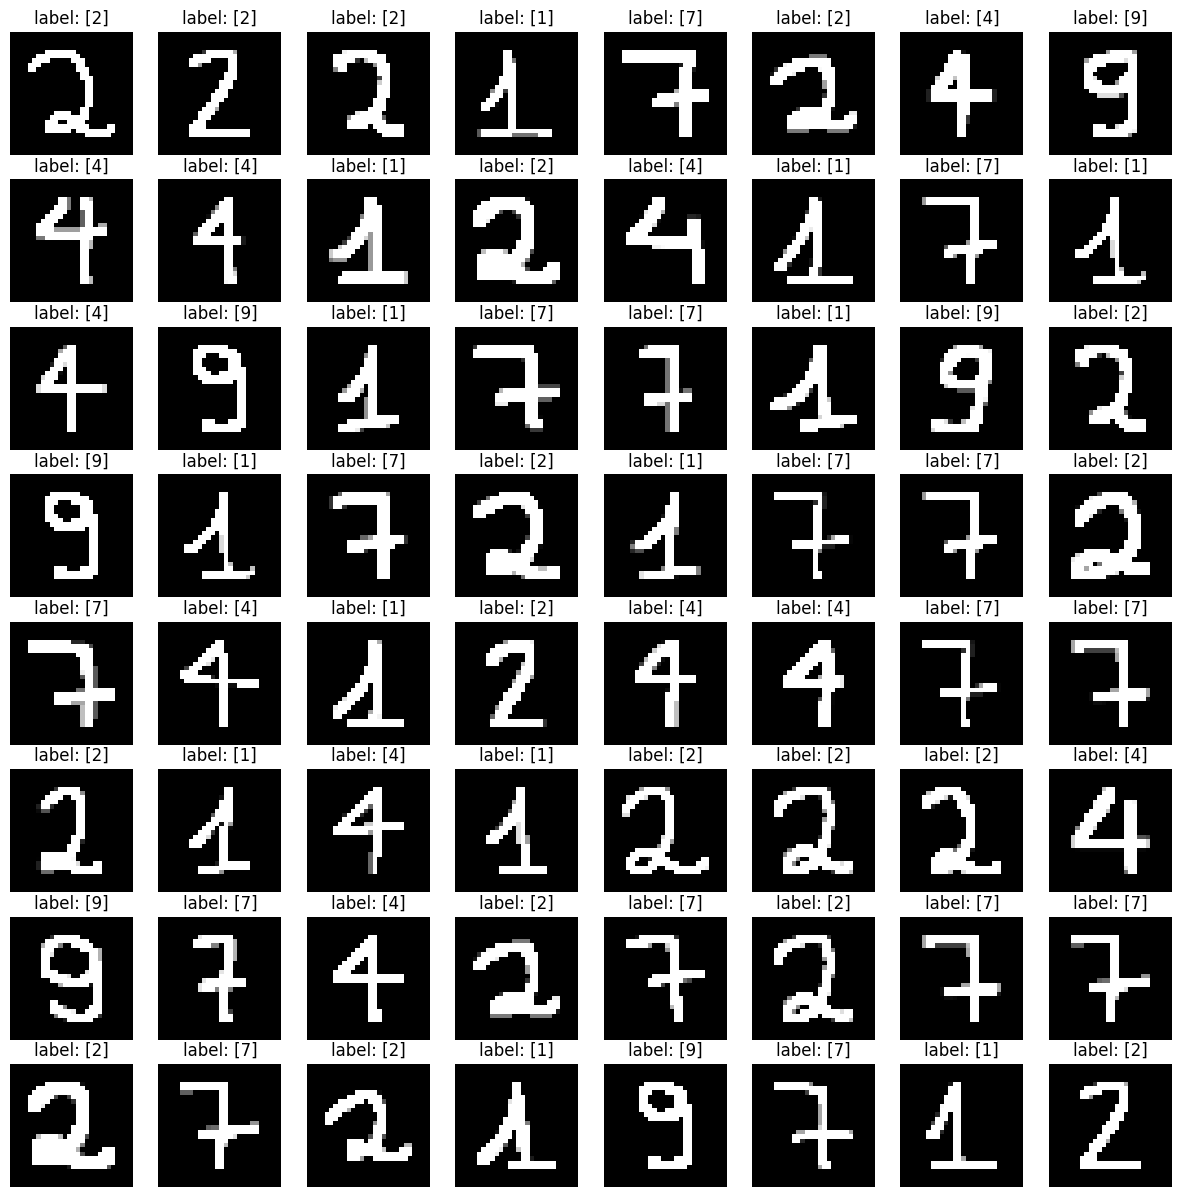

In [ ]:
#@title Reading and processing MNIST and augmented data

filepath = '/content/drive/MyDrive/Data/'
data_1 = pd.read_csv(filepath + 'MNIST_real.csv')
data_2 = pd.read_csv(filepath + "data_aug.csv")

data = data_1

x_aug1 = data_2.loc[:, '0' : '783'].to_numpy()
y_aug1 = data_2.loc[:, '784'].to_numpy().astype(np.uint8).reshape(-1, 1)

x_aug = []
y_aug = []

for i in range(x_aug1.shape[0]):
    if y_aug1[i] in [1, 2, 4, 7, 9]:
        x_aug.append(x_aug1[i, :])
        y_aug.append(y_aug1[i])

x_aug = np.array(x_aug)
y_aug = np.array(y_aug)

for i in range(4):
    x_aug = np.concatenate((x_aug, x_aug), axis = 0)
    y_aug = np.concatenate((y_aug, y_aug), axis = 0)

x = data.loc[:, '0':'783'].to_numpy()
y = data.loc[:, '784'].to_numpy().astype(np.uint8).reshape(-1, 1)

print(x.shape)
print(y.shape)

print(x_aug.shape)
print(y_aug.shape)

np.random.seed(1)
fig, ax = plt.subplots(8, 8, figsize = (15, 15))


for i in range(8):
    for j in range(8):
        random_index = np.random.randint(x_aug.shape[0])

        y_random = y_aug[random_index]
        x_random = x_aug[random_index, :].reshape(1, -1)
        ax[i, j].set_title("label: {}".format(y_random))
        ax[i, j].imshow(x_random.reshape(28, 28), cmap = 'gray')
        ax[i, j].axis('off')

x, y = preprocessData(x, y)
x_aug, y_aug = preprocessData(x_aug, y_aug)

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size = 1 / 7, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 12000, random_state = 42)
X_train = np.concatenate((X_train, x_aug), axis = 0)
y_train = np.concatenate((y_train, y_aug), axis = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


In [ ]:
#@title Training
layer_size_lst = [512, 256, 128, 10]
NN = NeuralNetwork(layer_size_lst)

NN.fit_batch(X_train, y_train, X_val, y_val, 128, 1e-3, 32, "Adam")


Iteration: 1, Train loss: 0.075831, Val loss: 0.07591, Accuracy on train: 75.203488, Accuracy on val: 75.558333
Iteration: 2, Train loss: 0.04089, Val loss: 0.041373, Accuracy on train: 87.071705, Accuracy on val: 87.208333
Iteration: 3, Train loss: 0.033659, Val loss: 0.034902, Accuracy on train: 90.031008, Accuracy on val: 89.441667
Iteration: 4, Train loss: 0.031353, Val loss: 0.032274, Accuracy on train: 90.313953, Accuracy on val: 90.316667
Iteration: 5, Train loss: 0.027456, Val loss: 0.028824, Accuracy on train: 91.786822, Accuracy on val: 91.3
Iteration: 6, Train loss: 0.025079, Val loss: 0.026936, Accuracy on train: 92.75969, Accuracy on val: 92.358333
Iteration: 7, Train loss: 0.023912, Val loss: 0.025787, Accuracy on train: 92.937984, Accuracy on val: 92.575
Iteration: 8, Train loss: 0.023275, Val loss: 0.02535, Accuracy on train: 93.125969, Accuracy on val: 92.425
Iteration: 9, Train loss: 0.02282, Val loss: 0.024595, Accuracy on train: 93.205426, Accuracy on val: 92.658333

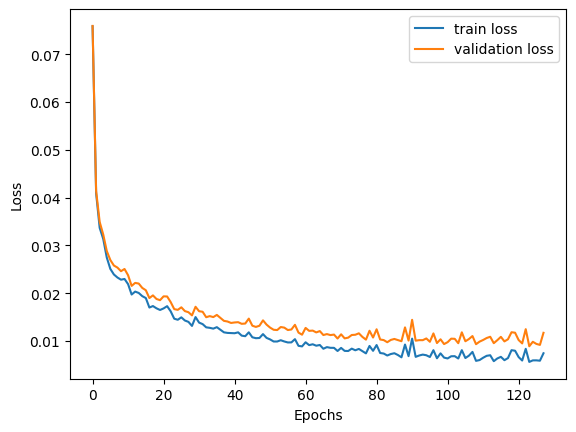

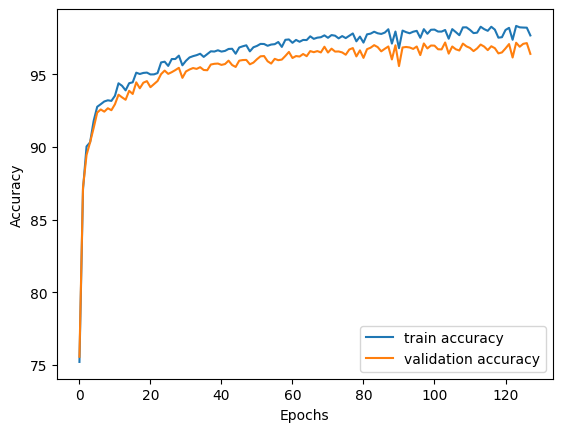

In [ ]:
NN.plot_cost()
NN.plot_acc()

In [ ]:
#Creating a dictionary only for weights
weight = {}
for l in range(1, NN.L + 1):
    weight["W" + str(l)] = NN.store["W" + str(l)]
    weight["b" + str(l)] = NN.store["b" + str(l)]

In [ ]:
#Save it
np.save(filepath + "MNIST_ver3.npy", weight) #save the Weight of the Neural Network